In [128]:
import json
import math
import os
import subprocess
from logging import getLogger
import pathlib
import glob

import numpy as np
from franklab_msdrift import tracking as track

/home/jojo/anaconda3/envs/franklab_mountainsort/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jojo/anaconda3/envs/franklab_mountainsort/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jojo/anaconda3/envs/franklab_mountainsort/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jojo/anaconda3/envs/franklab_mountainsort/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [129]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

### Get Dataset
Please input your downloaded data folder: include '/' at the end

In [ ]:
download_folder='/home/jojo/RemoteData2/shijie/animals/Jaq/mountainlab_output/'

In [13]:
# Get datset, (filtered raw timeseries and full sorted output(time index and label))
datestr='20190826'
electrodestr='18'
output_folder=download_folder+datestr+'/nt'+electrodestr

firings_list = []
timeseries_list = []
files=glob.glob(output_folder+'/*filt-*')
for segind in range(len(files)):
    pre_outpath = os.path.join(output_folder, f'filt-{segind + 1}.mda')
    firings_outpath = os.path.join(output_folder, f'firings-{segind + 1}.mda')
    firings_list.append(firings_outpath)
    timeseries_list.append(pre_outpath)

# Input metrics
hippo_options={}
hippo_options['metrics_file_name']='metrics_processed_nt'+electrodestr
hippo_options['metrics_file_folder']=os.path.join(output_folder,'metrics')

In [16]:
import itertools as it
import os
import json
from logging import getLogger
import numpy as np
from scipy.special import comb
from scipy.sparse import csc_matrix
from pyms.mlpy import DiskReadMda, readmda, writemda32, writemda64

### Preliminary: Calculating metrics
## WARNING
(This cell is not use-able for now as the code is highly dependent on the database folder structure)

In [ ]:
from franklab_msdrift.metrics import metrics_isolation
#from franklab_mountainsort.core import recalc_metrics_epoch

test_firing=os.path.join(os.path.join(output_folder,'metrics'),f'date{datestr}-n{str(electrodestr)}-firings-{1}.mda')
if len(os.listdir(os.path.join(output_folder,'metrics')))==0 or not os.path.isfile(test_firing):
    # get metrics
    mda_file_info = get_mda_files_dataframe(preprocessing_folder)
    mda_file_short = mda_file_info.query(f"electrode_number=={str(electrodestr)}&date=={datestr}") #query for a small set
    recalc_metrics_epoch(mda_file_short,
                         mountainlab_output_folder='/home/jojo/RemoteData2/abhilasha/animals/Jaq/mountainlab_output/',
                         data_folder=raw_data_dir,
                         updated_mda='firings_raw.mda', #should be in the file under mountainsort_output, can be replaced with other mdas
                         output_folder=os.path.join(output_folder,'metrics'),
                         mv2_file='', #optional, if labels are provided, the function will copy for you
                         num_workers=4, #parallel worker number
                         rm_segment_intermediates=False,
                         metrics_to_update='metrics_processed',
                         manual_only=False)
    for segind in range(len(sample_offsets)):
        firing_=os.path.join(os.path.join(output_folder,'metrics'),f'date{d}-n{str(e)}-firings-{segind + 1}.mda')
        metrics_isolation(timeseries=os.path.join(raw_data_dir,raw_file_name),
                              firing=firing_,
                              clip_size=50,
                              output_folder=os.path.join(output_folder,'metrics'),
                              output_name=f'metrics_processed_nt{e:02d}_epoch{segind + 1}'+'_updated.json')

### Run tracking

In [ ]:
(pairs_to_merge, dmatrix, k1_dmatrix, segment_combos, all_waveforms_first, all_waveforms_last, 
        all_K, noise_units,merged_pairs_units,MUA_units)=track.track(timeseries_list, firings_list, hippo_options=hippo_options)

### Run diagnostic plots:
##### The plot shows other non-max entries in the distance matrix. You should see that the majority (for example, 0.95%) of the entries are far from 1.

In [174]:
%%capture

from franklab_msdrift.p_calculate_ambiguity import ambiguity_metrics

all_K_old=[list(all_waveforms_first[i].keys()) for i in range(len(all_waveforms_first))]
Kmaxes=[np.max(all_K_old[i]) for i in range(len(all_K_old))]

(dist_other_min,dist_within,dist_inter,
        pairs_low_confidence,pairs_low_confidence_)=ambiguity_metrics(pairs_to_merge, dmatrix,
                                                        k1_dmatrix, k1_dmatrix, Kmaxes, segment_combos, excludes={})

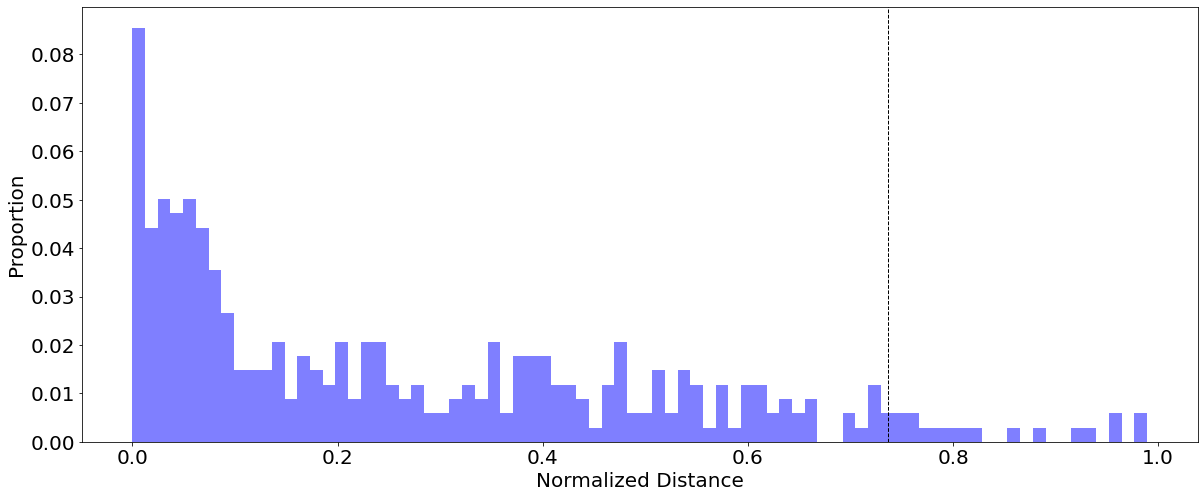

In [175]:
plt.figure(figsize=(20,8))

data_plot=dist_other_min
data_plot=data_plot[~np.isnan(data_plot)]

plt.hist(data_plot,color='b',alpha=0.5,weights=np.ones(len(data_plot))/len(data_plot),bins=80)

plt.axvline(np.quantile(data_plot,0.95), color='k', linestyle='dashed', linewidth=1) # plot the 0.95 quantile line
plt.xlabel('Normalized Distance',fontsize=20)
plt.ylabel('Proportion',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


#plt.xscale('log')
plt.yscale('linear')
plt.show()

### Finally, Output a table so that each line correspond to a unit that shows on multiple epochs, each column correspond to a unit within that epoch

In [202]:
(groups_all,goups_within_all,groups,groups_within)=track.chain_neuron(firings_list,np.vstack(pairs_to_merge))

In [203]:
groups_within

array([[ 2.,  0.,  0.,  0.,  0., 58.,  2.],
       [ 4.,  0.,  0.,  4.,  0.,  0.,  0.],
       [ 5., 14.,  3.,  5.,  0.,  0.,  3.],
       [10., 10., 10., 10., 10., 10.,  9.],
       [11., 11.,  0.,  0.,  0.,  0.,  0.],
       [ 0., 20.,  0., 20.,  0.,  0.,  0.],
       [ 7., 16.,  7., 32.,  7.,  4.,  7.],
       [ 0.,  0., 11., 11., 11., 11., 11.],
       [ 9.,  0.,  0.,  0.,  9.,  9.,  4.]])

### ------------------ The notebook stops here ------------------

In [18]:
num_segments = len(timeseries_list)
    # Get all possible segment combinations
segment_combos = it.combinations(range(num_segments), 2)
segment_combos = np.array(list(segment_combos))
    # Order segment combinations such that neighbors are first,
    # then non-neighbors
segment_combos = np.append(
    segment_combos[np.where(np.diff(segment_combos) == 1)[0], :],
    segment_combos[np.where(np.diff(segment_combos) > 1)[0], :], axis=0)

all_waveforms_first,all_waveforms_last=track.get_clips(timeseries_list,firings_list,clip_size=50)
all_K=[all_waveforms_first[i].keys() for i in range(len(all_waveforms_first))]

In [109]:
all_K_updated=[]
merged_pairs_all=[]
noise_all=[]

MUA_all=track.find_MUA(all_waveforms_first,all_waveforms_last)

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6


In [110]:
epoch=0

In [113]:
metrics_file_folder=hippo_options['metrics_file_folder']
metrics_file_name=hippo_options['metrics_file_name']
K_=list(all_waveforms_first[epoch].keys())
print('K_',K_)
metrics_file=os.path.join(metrics_file_folder,metrics_file_name+'_epoch'+str(epoch+1)+'.json')
metrics_file_updated=os.path.join(metrics_file_folder,metrics_file_name+'_epoch'+str(epoch+1)+'_updated.json')
        

noise_units=track.find_noise_units(metrics_file)
noise_all.append(noise_units)
K_=list(set(K_.copy())-set(noise_units))
print('K_ noise removed',K_)


MUA_units=MUA_all[epoch]  
K_=list(set(K_.copy())-set(MUA_units.tolist()))

#        exclude_units=np.concatenate((bursting_units,merged_pairs.ravel()))
#        MUA_units=find_MUA_units(metrics_file,metrics_file_updated,exclude_units)
#        MUA_all.append(MUA_units)

bursting_pairs=track.find_bursting_pairs(metrics_file)

K_ [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
K_ noise removed [2, 3, 4, 5, 7, 8, 9, 10, 11]


In [119]:
K_[0]

2

/home/jojo/anaconda3/envs/franklab_mountainsort/lib/python3.6/site-packages/franklab_msdrift/tracking.py:473: RuntimeWarning: All-NaN slice encountered
  min_tmp = np.zeros(X.shape[1-AXIS])+np.nan


In [14]:
(dmatrix, k1_dmatrix, segment_combos, all_waveforms_first, all_waveforms_last, 
                all_K, noise_units,merged_pairs_units,MUA_units)=track.get_dmatrix(timeseries_list, firings_list, hippo_options)

IndexError: tuple index out of range

In [ ]:
Kmaxes=[np.max(list(all_K[i].keys())) for i in range(len(all_K))]
pairs_to_merge_BOOT=track.get_join_matrix_bootstrap(1-dmatrix,Kmaxes,segment_combos)